In [2]:
import random
import sys
import time
from time import localtime, strftime

import epics
import h5py
import numpy as np
from matplotlib import pyplot as plt
from optlnls.math import get_fwhm
from optlnls.plot import plot_xy
from scipy.ndimage import rotate
from scipy.optimize import minimize_scalar

# List of necessary PVs

In [3]:
pv_und_phase_read = 'SI-09SA:ID-APU22:Phase-Mon'
pv_und_phase_write = 'SI-09SA:ID-APU22:Phase-SP'
pv_und_phase_moving = 'SI-09SA:ID-APU22:Moving-Mon'
pv_und_phase_start = 'SI-09SA:ID-APU22:DevCtrl-Cmd'

pv_DCM_energy_read = 'MNC:A:DCM01:GonRxEnergy_RBV'
pv_DCM_energy_write = 'MNC:A:DCM01:GonRxR'
pv_DCM_trajMove = 'MNC:A:DCM01:TrajMove'

# pv_DVF2_image = 'MNC:A:BASLER02:image1:ArrayData'
# pv_DVF2_exp_time = 'MNC:A:BASLER02:cam1:AcquireTime'
# pv_DVF2_acq_period = 'MNC:A:BASLER02:cam1:AcquirePeriod'

pv_DVF3_image = 'MNC:A:BASLER03:image1:ArrayData'
pv_DVF3_exp_time = 'MNC:A:BASLER03:cam1:AcquireTime'
pv_DVF3_acq_period = 'MNC:A:BASLER03:cam1:AcquirePeriod'

# Undulator emission related functions

In [4]:
def find_harmonics_given_energy(energy_points, min_energy=1.870,
                                max_energy=3.600, initial_harmonic=3,
                                print_points=False,
                                only_max_harmonic=False):
    """Find harmonic for given energy.

    Args:
        energy_points (list of floats): Energy values [keV]
        min_energy (float, optional): Minimum energy E1. Defaults to 1.870.
        max_energy (float, optional): Max energy E1. Defaults to 3.600.
        initial_harmonic (int, optional): Initial harmonic. Defaults to 3.
        print_points (int, optional): print points. Defaults to False.
        only_max_harmonic (bool, optional): only max harmonic. Defaults to
         False.

    Returns:
        list: List of points with [energy, harmonic].
    """
    scan_points = []
    for energy in energy_points:

        if only_max_harmonic:
            k = initial_harmonic
            while True:
                if ((energy / k >= min_energy) & (energy / k <= max_energy)):
                    max_harmonic = k
                elif (energy / k < min_energy):
                    break
                k += 2
            scan_points.append([energy, max_harmonic])

            if print_points:
                print(scan_points[-1])

        else:
            k = initial_harmonic
            while True:
                if ((energy / k >= min_energy) & (energy / k <= max_energy)):
                    scan_points.append([energy, k])
                    if print_points:
                        print(scan_points[-1])
                elif (energy / k < min_energy):
                    break
                k += 2
    return scan_points

def poly_any_degree(x, coefficients):
    """Generate a polynom with given coefficients.

    Args:
        x (1d numpy array): Points to evaluate polynom
        coefficients (1d numpy array): polynom's coefficients,
        ascending order.

    Returns:
        1d numpy array: Polynom calculated in points x.
    """
    return np.polyval(coefficients[::-1], x)

def _search_phase(x, *args):
    energy = args[0]
    coeffs = args[1]
    return np.abs(poly_any_degree(x, coeffs) - energy)

def get_phase_from_energy_h1(energy, coefficients, bounds=None):
    """Get phase for given H1 energy.

    Args:
        energy (float): Energy in keV
        coefficients (1d numpy array): E1 vs phase coeefficients
        bounds (2 element float list, optional): Bounds for phase search.
            Defaults to None.

    Returns:
        float: Phase for fiven energy
    """
    if bounds is None:
        bounds = [0, 11]

    args = (energy, coefficients)
    res = minimize_scalar(_search_phase,
        args=args, bounds=bounds, method='bounded')
    return res.x

def get_manaca_poly_coefficients():
    """Manaca E1 vs phase curve coefficients.

       Updated on 2022-06-10.

    Returns:
        1d numpy array: Polynom coefficients.
    """
    poly_coeffs = np.array([1.87967e+00,
                            7.27222e-06,
                            2.07199e-02,
                            -5.43703e-04,
                            4.02718e-04,
                            -1.07571e-04,
                            1.92051e-05,
                            -1.76339e-06,
                            5.52816e-08])

    return poly_coeffs

def get_phase_from_energy(energy_value=12.00, harmonic_number=5, verbose=True):
    """Find phase for given harmonic and energy.

    Args:
        energy_value (float, optional): Energy value [keV]. Defaults to 12.00.
        harmonic_number (int, optional): Harmonic. Defaults to 5.
        verbose (int, optional): Print info. Defaults to True.

    Returns:
        float: Phase
    """
    # Find possible harmonics
    harmonics = find_harmonics_given_energy(energy_points=[energy_value],
                                            only_max_harmonic=False)

    harmonics = np.array(harmonics)
    harmonics = harmonics[:, 1].astype(int)

    if harmonic_number in harmonics:

        energy1 = energy_value / harmonic_number
        poly_coefficients = get_manaca_poly_coefficients()
        phase = get_phase_from_energy_h1(energy1, poly_coefficients,
            bounds=[0, 10])
        phase = round(phase, 3)

        if verbose:
            print('phase value is:', phase)
            print('energy:', energy_value, 'keV')
            print('h =', harmonic_number)
            print('fundamental energy =', round(energy1, 3))

    else:
        if verbose:
            print('harmonic h =', harmonic_number,
                'is not valid for this energy.')
            print('please choose a valid harmonic number')
        phase = np.nan

    if verbose:
        print('\n')
        print('possible harmonics for this energy are:')
        for h in harmonics:
            print('h =', h)

    return phase

def get_current_value():
    """Get storage ring current.

    Returns:
        float: current value.
    """
    return epics.caget('SI-Glob:AP-CurrInfo:Current-Mon')

def put_undulator(value):
    """Set undulator phase and start movement.

    Args:
        value (float): Phase value.
    """
    epics.caput(pv_und_phase_write, value, wait=True)
    time.sleep(0.5)
    epics.caput(pv_und_phase_start, 3, wait=True)

# Generate Fundamental Harmonic vs Undulator Phase

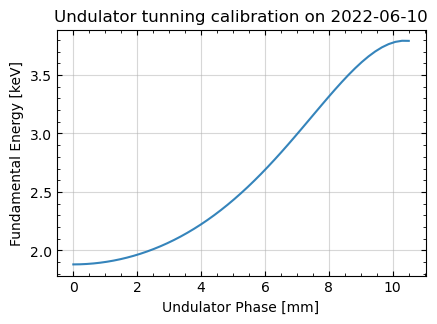

In [5]:
# create a list of phase values
phase_values = np.linspace(0, 10.5, 51)

# the calibration is converted into a 8th degree fitted polynomial
poly_coefficients = get_manaca_poly_coefficients()

# use the coefficients to generate the calibrated function
fundamental_energies = poly_any_degree(phase_values, poly_coefficients)

plot_xy(phase_values, fundamental_energies,
       xlabel='Undulator Phase [mm]', ylabel='Fundamental Energy [keV]',
       title='Undulator tunning calibration on 2022-06-10')


# Image acquisition and processing related functions

In [6]:
def get_image_max_value(image_pv, shape=None, binning=None, plot_image=False):
    """Get max image max value.

    Args:
        image_pv (str): Image pv
        shape (list of ints, optional): Image shape. Defaults to None.
        binning (list of ints, optional): Average image. Defaults to None.
        plot_image (bool, optional): Plot image. Defaults to False.

    Returns:
        float: max value
    """
    if binning is None:
        binning = [1, 1]
    if shape is None:
        shape = [1024, 1280, 1]

    # acquire image
    img = np.array(epics.caget(image_pv))  # get image from pv
    img = img.reshape(shape[0], shape[1], shape[2])  # reshape array
    img = img[:, :, 0]  # get the RGB channel

    # bin image to avoid saturating noise
    if binning != [1, 1]:
        img = bin_matrix(img, binning[0], binning[1])

    # get maximum value
    img_max = np.max(img)

    if plot_image:
        fig, ax = plt.subplots(figsize=(12, 8))
        im = ax.imshow(img, origin="lower")
        fig.colorbar(im, ax=ax)
        plt.show()

    return img_max

def adjust_exposure_time(
    image_pv,
    exp_time_pv,
    saturation=256,
    threshold=None,
    shape=None,
    binning=None,
    exp_time_max=1,
    debug=False,
):
    """Adjust exposure time.

    Args:
        image_pv (str): Image pv
        exp_time_pv (str): Exposure time pv name
        saturation (int, optional): Saturation value. Defaults to 256 for 8b.
        threshold (list of floats, optional): Max and minimum desired values
         for image max value. Defaults to None.
        shape (list of ints, optional): Image shape. Defaults to None.
        binning (list of ints, optional): Average image. Defaults to None.
        exp_time_max (float, optional): Max exp time [ms]. Defaults to 1.
        debug (Boolean, optional): Print steps. Defaults to False.

    Returns:
        _type_: _description_
    """
    if shape is None:
        shape = [1024, 1280, 1]
    if binning is None:
        binning = [1, 1]
    if threshold is None:
        threshold = [0.75, 0.85]

    # import epics
    img_max = get_image_max_value(image_pv, shape, binning)

    # check if exposure time is ok
    exp_time_is_bad = (img_max < threshold[0] * saturation) or (
        img_max > threshold[1] * saturation
    )
    exp_time = float(epics.caget(exp_time_pv))

    # optimize exposure time
    if exp_time_is_bad:
        print("exposure time is bad. trying to optimize... ")

        if debug:
            print("\t exposure time is ", round(exp_time, 3))

        trial_number = 0
        while exp_time_is_bad:
            trial_number += 1
            if debug:
                print("\t trial number is ", trial_number)

            # avoid infinite loops
            if trial_number > 20:
                if debug:
                    print("\t failed to optimize exposure time")
                break

            img_max = get_image_max_value(image_pv, shape, binning)
            if debug:
                print("\t image maximum is", round(img_max, 1))

            # if is saturated, divide time by 2
            if img_max >= threshold[1] * saturation:
                exp_time = round(exp_time / 2, 4)
                epics.caput(exp_time_pv, exp_time, wait=True)
                if debug:
                    print(
                        "\t image saturated. changing exp time to ", exp_time
                    )
                time.sleep(2 * exp_time)

            # if exposure time is too low, estimate the ideal value
            elif img_max <= threshold[0] * saturation:
                if img_max >= saturation * 0.05:
                    # increase_factor = np.mean(threshold)*saturation / img_max
                    increase_factor = 1.2
                else:
                    increase_factor = 2.0

                exp_time = round(exp_time * increase_factor, 4)

                # only increase if it is less than maximum allowed time
                if exp_time <= exp_time_max:
                    epics.caput(exp_time_pv, exp_time, wait=True)
                    if debug:
                        print(
                            "\t image underexposed. changing exp time to ",
                            exp_time,
                        )
                    time.sleep(2 * exp_time)

                else:
                    str_ = "\t calculated exposition time larger than allowed."
                    str_ += " Optimization failed."
                    print(str_)
                    epics.caput(exp_time_pv, exp_time_max, wait=True)
                    time.sleep(2 * exp_time_max)
                    break

            # else, exposure time is ok
            else:
                exp_time_is_bad = False
                print(
                    "\t exp time set to {0:.3f} . max value = {1:.1f}".format(
                        exp_time, img_max
                    )
                    + " optimization was successful. \n"
                )
        return exp_time

    else:
        print("   no need to optimize exposure time")
        return exp_time

def bin_matrix(matrix, binning_y, binning_x):
    """Bin matrix (average matrix).

    Args:
        matrix (2d numpy array): Image matrix
        binning_y (int): Nr pts to bin vertical
        binning_x (int): Nr pts to bin horizontal

    Returns:
        2d numpy array: Binned matrix
    """
    yn, xn = matrix.shape

    if (xn % binning_x != 0) or (yn % binning_y != 0):
        print(
            "array of shape ({0} x {1}) cannot be binned by factor ({2},{3})".format(
                yn, xn, binning_y, binning_x
            )
        )
        return matrix

    else:
        xn = int(xn / binning_x)
        yn = int(yn / binning_y)

        matrix_binned = np.zeros((yn, xn), dtype=float)

        count_y = 0
        for iy in range(yn):
            count_x = 0
            for ix in range(xn):
                matrix_binned[iy, ix] = np.sum(
                    matrix[
                        count_y : count_y + binning_y,
                        count_x : count_x + binning_x,
                    ]
                )

                count_x += binning_x
            count_y += binning_y

        matrix_binned /= binning_x * binning_y

        if 0:
            fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
            im0 = ax[0].imshow(matrix, origin="lower")
            im1 = ax[1].imshow(matrix_binned, origin="lower")
            fig.colorbar(im0, ax=ax[0])
            fig.colorbar(im1, ax=ax[1])

            plt.show()

        return matrix_binned

def acquire_image(
    image_pv, shape=None, binning=None, plot_image=False
):
    """Acquire image.

    Args:
        image_pv (str): Image pv
        shape (list of ints, optional): Image shape. Defaults to None.
        binning (list of ints, optional): Average image. Defaults to None.
        plot_image (bool, optional): Plot image. Defaults to False.

    Returns:
        2d numpy array: Array with image data
    """
    if shape is None:
        shape = (1024, 1280)
    if binning is None:
        binning = (1, 1)

    img = np.array(epics.caget(image_pv))
    img = img.reshape(shape)

    if binning != (1, 1):
        img = bin_matrix(img, binning[0], binning[1])

    if plot_image:
        fig, ax = plt.subplots(figsize=(6, 4))
        im = ax.imshow(img, origin="lower", cmap="jet")
        fig.colorbar(im, ax=ax)
        plt.show()

    return img

def get_centroid(img, x=0, y=0):
    """Get image centroid.

    Args:
        img (2d numpy array): Image
        x (int, optional): Image points. Defaults to 0.
        y (int, optional): Image points. Defaults to 0.

    Returns:
        tuple of ints: Centroid position (y0, x0)
    """
    shape = img.shape
    if x == 0:
        x = np.arange(0, shape[1])
    if y == 0:
        y = np.arange(0, shape[0])

    ix = np.sum(img, axis=0)
    iy = np.sum(img, axis=1)

    x_mean = int(np.round(np.average(x, weights=ix)))
    y_mean = int(np.round(np.average(y, weights=iy)))
    return (y_mean, x_mean)

def get_vertical_cut(img, x=0, nx=20, binning=(1, 1), plot_cut=False):
    """Get vertical cut.

    Args:
        img (2d numpy array): Image
        x (int, optional): x position to do cut. Defaults to 0.
        nx (int, optional): nr of y points to get. Defaults to 20.
        binning (tuple, optional): Bin matrix. Defaults to (1, 1).
        plot_cut (bool, optional): Plot cut. Defaults to False.

    Returns:
        1d numpy array: cut
    """
    if binning != (1, 1):
        img = bin_matrix(img, binning[0], binning[1])

    if nx == 1:
        xmin = int(x)

    elif nx > 1:
        xmin = int(x - nx / 2)

    xmax = int(xmin + nx)

    cut = np.sum(img[:, xmin:xmax], axis=1) / nx

    if plot_cut:
        plt.figure()
        plt.plot(cut)
        plt.show()

    return cut

def define_ROI(
    pv_prefix="MNC:A:BASLER02",
    ROI_shape=(400, 400),
    ROI_start=(0, 0),
    ROI_binning=(1, 1),
):
    """Define region of interest (ROI).

    Args:
        pv_prefix (str, optional): pv prefix. Defaults to "MNC:A:BASLER02".
        ROI_shape (tuple, optional): _description_. Defaults to (400, 400).
        ROI_start (tuple, optional): _description_. Defaults to (0, 0).
        ROI_binning (tuple, optional): _description_. Defaults to (1, 1).
    """
    pv_image = pv_prefix + ":image1:ArrayData"

    # enable ROI
    epics.caput(pv_prefix + ":ROI1:EnableCallbacks", 1, wait=True)
    epics.caput(pv_prefix + ":image1:NDArrayPort", "ROI1", wait=True)

    # set ROI
    epics.caput(pv_prefix + ":ROI1:MinX", ROI_start[1], wait=True)
    epics.caput(pv_prefix + ":ROI1:MinY", ROI_start[0], wait=True)

    epics.caput(pv_prefix + ":ROI1:SizeX", ROI_shape[1], wait=True)
    epics.caput(pv_prefix + ":ROI1:SizeY", ROI_shape[0], wait=True)

    epics.caput(pv_prefix + ":ROI1:BinX", ROI_binning[1], wait=True)
    epics.caput(pv_prefix + ":ROI1:BinY", ROI_binning[0], wait=True)

    time.sleep(1)

def initialize_hdf5(h5_filename):
    """Initialize a h5 file.

    Args:
        h5_filename (str): File name
    """
    with h5py.File(h5_filename, "w") as f:
        f.attrs["begin time"] = time.strftime(
            "%Y-%m-%d %H:%M:%S", time.localtime()
        )
        f.create_group("images")
        f.create_group("vertical_cuts")

def end_hdf5(h5_filename):
    """Finish a h5 file.

    Args:
        h5_filename (str): File name
    """
    with h5py.File(h5_filename, "a") as f:
        f.attrs["end time"] = time.strftime(
            "%Y-%m-%d %H:%M:%S", time.localtime()
        )

def create_group(h5_filename, group_name, group_attributes):
    """Create a group in h5 file.

    Args:
        h5_filename (str): File name
        group_name (str): Group name
        group_attributes (dict): Group attributes
    """
    with h5py.File(h5_filename, "a") as f:
        group_images = f["images"].create_group(group_name)
        group_cuts = f["vertical_cuts"].create_group(group_name)

        for i in range(len(group_attributes)):
            group_images.attrs[group_attributes[i][0]] = group_attributes[i][1]
            group_cuts.attrs[group_attributes[i][0]] = group_attributes[i][1]

def append_image_to_hdf5(
    h5_filename, group_name, dataset_name, image, attributes
):
    """Add image to h5 file.

    Args:
        h5_filename (str): File name
        group_name (str): Group name
        dataset_name (_type_): _description_
        image (_type_): _description_
        attributes (_type_): _description_
    """
    with h5py.File(h5_filename, "a") as f:
        group = f["images/" + group_name]
        dset = group.create_dataset(
            dataset_name, data=image, compression="gzip"
        )

        for i in range(len(attributes)):
            dset.attrs[attributes[i][0]] = attributes[i][1]

def append_cut_to_hdf5(h5_filename, group_name, dataset_name, cut, attributes):
    """Append cut to h5 file.

    Args:
        h5_filename (str): File name
        group_name (str): Group name
        dataset_name (_type_): _description_
        cut (_type_): _description_
        attributes (_type_): _description_
    """
    with h5py.File(h5_filename, "a") as f:
        group = f["vertical_cuts/" + group_name]
        dset = group.create_dataset(dataset_name, data=cut, compression="gzip")

        for i in range(len(attributes)):
            dset.attrs[attributes[i][0]] = attributes[i][1]

# Define ROI

In [ ]:
# roi_shape = (1024,1280)
# roi_start = (0,0)

roi_shape = (400, 400)
roi_start = (32, 860)

define_ROI(
    pv_prefix="MNC:A:BASLER03",
    ROI_shape=roi_shape,
    ROI_start=roi_start,
    ROI_binning=(1, 1),
)

pv_DVF_image = pv_DVF3_image

img = np.array(epics.caget(pv_DVF_image))
img = img.reshape(roi_shape)

fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(img, cmap="viridis", origin="lower")
fig.colorbar(im, ax=ax)
ax.vlines(x=200, ymin=0, ymax=400, color="w", linestyle="--", alpha=0.3)
ax.hlines(y=200, xmin=0, xmax=400, color="w", linestyle="--", alpha=0.3)

# np.savetxt('/home/ABTLUS/xafs/data/2021-03-27/DVF3_dark_field_39p8mA_010ms_no_led.txt', img)

# Define Scan Points

In [10]:
harmonic = 5
de = 0.1

energy_points_e7 = np.linspace(13.235 - de, 13.235 + de, 11)
energy_points_e5 = np.linspace(9.454 - de, 9.454 + de, 11)
energy_points_e3 = np.linspace(5.672 - de, 5.672 + de, 11)

if harmonic == 3:
    energy_points = energy_points_e3
elif harmonic == 5:
    energy_points = energy_points_e5
elif harmonic == 7:
    energy_points = energy_points_e7
else:
    print('Invalid harmonic')

scan_points = []
phase = 0
for i, energy in enumerate(energy_points):
    point_to_scan = [energy, phase, harmonic]
    scan_points.append(point_to_scan)
    print(point_to_scan)

print("total number of points to scan is", len(scan_points))

# shuffle points
# random.shuffle(scan_points)
# for point in scan_points:
#     print(point)


[9.354000000000001, 0, 5]
[9.374, 0, 5]
[9.394, 0, 5]
[9.414000000000001, 0, 5]
[9.434000000000001, 0, 5]
[9.454, 0, 5]
[9.474, 0, 5]
[9.494, 0, 5]
[9.514000000000001, 0, 5]
[9.534, 0, 5]
[9.554, 0, 5]
total number of points to scan is 11


In [11]:
scan_points

[[9.354000000000001, 0, 5],
 [9.374, 0, 5],
 [9.394, 0, 5],
 [9.414000000000001, 0, 5],
 [9.434000000000001, 0, 5],
 [9.454, 0, 5],
 [9.474, 0, 5],
 [9.494, 0, 5],
 [9.514000000000001, 0, 5],
 [9.534, 0, 5],
 [9.554, 0, 5]]

In [ ]:
np.linspace(-0.06, 0.06, 13)

# 2. Start Scan 

In [ ]:

time_str = time.strftime("%Y-%m-%d_%Hh%Mm%Ss", time.localtime())
h5_filename  = '/home/ABTLUS/xafs/data/2021-03-27/'
h5_filename += 'MAN_emit_scan_5mA_' + time_str + '.h5'

initialize_hdf5(h5_filename)

delta_energy_array = np.linspace(-0.06, 0.06, 13)
delta_DCM = 0.5e-3
img_shape = [roi_shape[0], roi_shape[1], 1]


for i in range(len(scan_points)):

    ############################################
    ## do caputs

    DCM_value, UND_value, harmonic = scan_points[i]
    #DCM_value += delta_energy_array[0]

    print('\n')
    print('Moving... step {0} out of {1}'.format(i+1, len(scan_points)))
    print('DCM Energy = {0:.3f} keV at harmonic {1}'.format(DCM_value, harmonic))
    print('UND Phase = {0:.3f} mm'.format(UND_value))

    if(1):

        put_undulator(UND_value)

        put_DCM(DCM_value, pv_DCM_energy_write, pv_DCM_trajMove)

        print('waiting...')

        t0 = time.time()
        moving = 1
        while moving:
            time.sleep(0.1)
            DCM_diff = np.abs(epics.caget(pv_DCM_energy_read) - DCM_value)
            DCM_moving = DCM_diff >= delta_DCM
            UND_moving = epics.caget(pv_und_phase_moving)
            moving = UND_moving or DCM_moving

            if(time.time() - t0 > 10):
                put_DCM(DCM_value, pv_DCM_energy_write, pv_DCM_trajMove)
                t0 = time.time()

        print('finished moving!')

        time.sleep(0.5)

    if(1):
        print('starting acquisition...')

        group_name = 'E_{0:.3f}keV_z_{1:.3f}mm'.format(scan_points[i][0], UND_value)

        group_attributes = []
        group_attributes.append(['DCM Central Energy', scan_points[i][0]])
        group_attributes.append(['Undulator Phase', UND_value])
        group_attributes.append(['Harmonic', harmonic])

        create_group(h5_filename, group_name, group_attributes)

        exp_time = adjust_exposure_time(pv_DVF3_image, pv_DVF3_exp_time, saturation=2**8,
                                        threshold=[0.7, 0.85], shape=img_shape,
                                        binning=[4,4], exp_time_max=1.1, debug=0)

        time.sleep(0.5)
        #nput('PRESS ANY BUTTON')

        #### scan energies around central energy
        for j, delta_energy in enumerate(delta_energy_array):

            DCM_value_new = DCM_value + delta_energy

            put_DCM(DCM_value_new, pv_DCM_energy_write, pv_DCM_trajMove)

            print('     waiting... DCM going to {0:.3f}'.format(DCM_value_new))

            t0 = time.time()
            moving = 1
            while moving:
                time.sleep(0.1)
                DCM_diff = np.abs(epics.caget(pv_DCM_energy_read) - DCM_value_new)
                DCM_moving = DCM_diff >= delta_DCM
                moving = DCM_moving

                if(time.time() - t0 > 5):
                    put_DCM(DCM_value_new, pv_DCM_energy_write, pv_DCM_trajMove)
                    t0 = time.time()

            time.sleep(0.5)

            print('     acquiring...')
            acquisition_time = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())
            current = get_current_value()

            ### acquire image
            img = acquire_image(pv_DVF3_image, roi_shape)
            img_sum = np.sum(img)

            ### get centroid
            centroid_y, centroid_x = get_centroid(img)


            img_attributes = []
            #img_attributes.append(['Undulator Phase', UND_value])
            img_attributes.append(['DCM Energy', DCM_value_new])
            img_attributes.append(['Integral', img_sum])
            img_attributes.append(['Current', current])
            img_attributes.append(['CentroidX', centroid_x])
            img_attributes.append(['CentroidY', centroid_y])
            img_attributes.append(['Acquisition Time', acquisition_time])
            img_attributes.append(['Exposure Time', exp_time])

            dataset_name = 'E_{0:.3f}keV'.format(DCM_value_new)
            append_image_to_hdf5(h5_filename, group_name, dataset_name, img, img_attributes)

            if(1):
                ### do a vertical cut
                cut_binning = 4
                cut = get_vertical_cut(img, x=centroid_x, nx=10, binning=(cut_binning,1))

                ### get fwhm value
                fwhm_pts = get_fwhm(np.arange(0, int(roi_shape[0]/cut_binning)), cut,
                                    inmost_outmost=1, oversampling=200)
                fwhm = fwhm_pts[0] * cut_binning

                cut_attributes = []
                cut_attributes.append(['FWHM', fwhm])

                append_cut_to_hdf5(h5_filename, group_name, dataset_name, cut, cut_attributes)

        if(i == len(scan_points) - 1):
            end_hdf5(h5_filename)


print("FINISHED!!")


## Tests

In [ ]:
aquire_image(pv_DVF2_image, shape=(1024,1280), filename=prefix)

In [ ]:
array([ 1.87023258e+00, -2.28529023e-03,  2.00948508e-02,  2.49778389e-03,
       -1.32115446e-03,  3.25708366e-04, -3.73207112e-05,  1.96384705e-06,
       -4.24686251e-08])

In [ ]:
put_DCM(9.1, pv_DCM_energy_write, pv_DCM_trajMove)

In [ ]:
put_undulator(11.0, pv_und_phase_write, pv_und_phase_start)

In [ ]:
img = np.array(epics.caget(pv_DVF2_image))

img = img.reshape((1024,1280))

plt.figure()
plt.imshow(img, origin='lower')


In [ ]:
epics.caput(pv_DVF2_exp_time, 0.02 * 1e6)


In [ ]:
epics.caget(pv_DVF2_exp_time)

In [ ]:
adjust_exposure_time(pv_DVF2_image, pv_DVF2_exp_time, saturation=2**16,
                         threshold=[0.7, 0.9], shape=[1024, 1280, 1],
                         binning=[4,4], exp_time_max=1.1, debug=0)

In [ ]:
pv_DVF2_image = 'MNC:A:BASLER02:image1:ArrayData'


img = np.array(epics.caget(pv_DVF2_image))
#img = img.reshape((294, 400))
img = img.reshape((1024, 1280))

plt.figure()
plt.imshow(img)


In [ ]:
epics.caput('MNC:A:BASLER02:image1:NDArrayPort', 'ROI1')

In [ ]:
epics.caget('MNC:A:BASLER02:image1:ArraySize0_RBV')

In [ ]:
epics.caget('MNC:A:BASLER02:cam1:ArraySizeX_RBV')
epics.caget('MNC:A:BASLER02:cam1:ArraySizeY_RBV')
epics.caget('MNC:A:BASLER02:cam1:ArraySizeZ_RBV')

In [ ]:


#     ny = epics.caget('MNC:A:BASLER02:image1:ArraySize0_RBV')
#     nx = epics.caget('MNC:A:BASLER02:image1:ArraySize1_RBV')


In [ ]:
image_pv = 'MNC:A:BASLER02:image1:ArrayData'
exp_time_pv = 'MNC:A:BASLER02:cam1:AcquireTime'

shape = [roi_shape[0], roi_shape[1], 1]

adjust_exposure_time(image_pv, exp_time_pv, saturation=2**16,
                     threshold=[0.4, 0.7], shape=shape,
                     binning=[1,1], exp_time_max=1, debug=1)

In [ ]:
img = acquire_image(pv_DVF2_image, roi_shape, binning=(1,1), plot_image=1)

centroid_y, centroid_x = get_centroid(img)
print(centroid_y, centroid_x)
cut_binning = 4
cut = get_vertical_cut(img, x=centroid_x, nx=20, binning=(cut_binning,1), plot_cut=1)
fwhm_pts = get_fwhm(np.arange(0, int(roi_shape[0]/cut_binning)), cut)
fwhm = fwhm_pts[0] * cut_binning

In [ ]:
filename00 = 'SCAN1_2020-12-09_19-26-14.h5'

img = acquire_image(pv_DVF2_image, [1024,1280], binning=(1,1), plot_image=1)

centroid_y, centroid_x = get_centroid(img)
print(centroid_y, centroid_x)
cut_binning = 4
cut = get_vertical_cut(img, x=centroid_x, nx=20, binning=(cut_binning,1), plot_cut=1)
print(len(cut))
fwhm_pts = get_fwhm(np.arange(0, int(1024/cut_binning)), cut)
fwhm = fwhm_pts[0] * cut_binning

attributes = [['laaaa', 2], ['bshsb', 454]]
gname='ushd'
dname='uhuhuh'
append_image_to_hdf5(h5_filename, gname, dname, img, attributes, attributes)

append_cut_to_hdf5(h5_filename, gname, dname, cut, attributes, attributes)
